Benchmarks and comparison for built-in compression algorithms and methods from GDAL (lossless and loss)

Conditions:
  - Provided for GeoTIFF/TIFF formats
  - Tested both compression and decompression process
  - Some overhead by using Python itself and bindings (TODO: use gdal_translate via CLI directly for compurational efficiency and Bash scrips - subprocess or os.system)
  - Measurements:
    - Compressed ratio - $\text{Compression Ratio} = \dfrac{\text{Uncompressed Size}}{\text{Compressed Size}}$
  
    - Space saving (in percent) - $\text{Space Saving} = (1 - \dfrac{\text{Compressed Size}}{\text{Uncompressed Size}}) * 100\%$
  
    - Information entropy / Shannon entropy - (TODO: properly calculate for 2D formats)
  
    - Read/Write speeds (CPU-bound and IO-bound operations)
  
  - Image sizes, formats, data types: 
    - byte_50m, float32_50m, int16_50m
  - Parameters and configuration options:
    - "LZW", "PACKBITS", "DEFLATE",  "LZMA", "ZSTD", "LERC", "LERC_DEFLATE", "LERC_ZSTD", "NONE"
  - Device specs / stats: WSL2, AMD Ryzen 5 5600 3.50 GHz, 32GB RAM (TODO: other specifications)

In [3]:
import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from osgeo import gdal

gdal.UseExceptions()

In [4]:
directory = Path("../data/")
files = list(directory.glob("*.tif"))


def get_entropy_value(file_path: str):
    # TODO: for different dtypes, colorscales, multilayered / multiple bands images
    img = np.fromfile(file_path, dtype=np.int16)
    marg = np.histogramdd(np.ravel(img), bins = 256)[0] / img.size
    marg = list(filter(lambda p: p > 0, np.ravel(marg)))
    entropy = -np.sum(np.multiply(marg, np.log2(marg)))
    return entropy


for idx, file in enumerate(files):
    entropy = get_entropy_value(file)
    print(idx, file, entropy)

0 ../data/float32_50m.tif 7.847451335285388
1 ../data/int16_50m.tif 2.8876208132776195
2 ../data/byte_50m.tif 5.297657221793088


In [ ]:
compress_types = ["LZW", "PACKBITS", "DEFLATE",  "LZMA", "ZSTD", "LERC", "LERC_DEFLATE", "LERC_ZSTD", "NONE"]
# "JPEG", "CCITTRLE", "CCITTFAX3", "CCITTFAX4", "WEBP", "JXL"

results = []

for compress_type in compress_types:
    compress_directory = directory / f"{compress_type}/"
    compress_directory.mkdir(exist_ok=True)
    
for idx, file in enumerate(files):
    try:
        raster_object = gdal.Open(file, gdal.GA_ReadOnly)
    except Exception as e:
        print(e)
    
    original_size = os.path.getsize(file)
    
    for compress_type in compress_types:
        start_time = time.time()
        output_path = directory / f"{compress_type}/output_{idx}.tif"
        # raster_object =
        gdal.Translate(
            destName=output_path,
            srcDS=raster_object,
            options = gdal.TranslateOptions(
                creationOptions=[f"COMPRESS={compress_type}"]
            )
        )
        
        end_time = time.time() - start_time
        compressed_size = os.path.getsize(output_path)
        compression_ratio = original_size / compressed_size if compressed_size != 0 else 0
        
        results.append({
            "file": file.name,
            "compression_type": compress_type,
            "original_size_mb": original_size / (1024 * 1024),
            "compressed_size_mb": compressed_size / (1024 * 1024),
            "compression_ratio": compression_ratio,
            "time_s": end_time
        })
        
        print(f"{compress_type} | {file.name} | Time: {end_time:.2f}s | Ratio: {compression_ratio:.2f}")
        
    del raster_object
    raster_object = None

LZW | float32_50m.tif | Time: 0.69s | Ratio: 0.96
PACKBITS | float32_50m.tif | Time: 0.22s | Ratio: 0.99
DEFLATE | float32_50m.tif | Time: 0.59s | Ratio: 1.19
LZMA | float32_50m.tif | Time: 10.09s | Ratio: 1.05
ZSTD | float32_50m.tif | Time: 0.36s | Ratio: 1.19
LERC | float32_50m.tif | Time: 0.25s | Ratio: 1.00
LERC_DEFLATE | float32_50m.tif | Time: 0.69s | Ratio: 1.19
LERC_ZSTD | float32_50m.tif | Time: 0.70s | Ratio: 1.19
NONE | float32_50m.tif | Time: 0.09s | Ratio: 1.00
LZW | int16_50m.tif | Time: 0.77s | Ratio: 1.20
PACKBITS | int16_50m.tif | Time: 0.21s | Ratio: 0.99
DEFLATE | int16_50m.tif | Time: 0.59s | Ratio: 1.57
LZMA | int16_50m.tif | Time: 13.90s | Ratio: 1.70
ZSTD | int16_50m.tif | Time: 0.90s | Ratio: 1.50
LERC | int16_50m.tif | Time: 2.55s | Ratio: 1.59
LERC_DEFLATE | int16_50m.tif | Time: 0.95s | Ratio: 1.86
LERC_ZSTD | int16_50m.tif | Time: 1.43s | Ratio: 1.81
NONE | int16_50m.tif | Time: 0.09s | Ratio: 1.00
LZW | byte_50m.tif | Time: -1.03s | Ratio: 1.98
PACKBITS | b

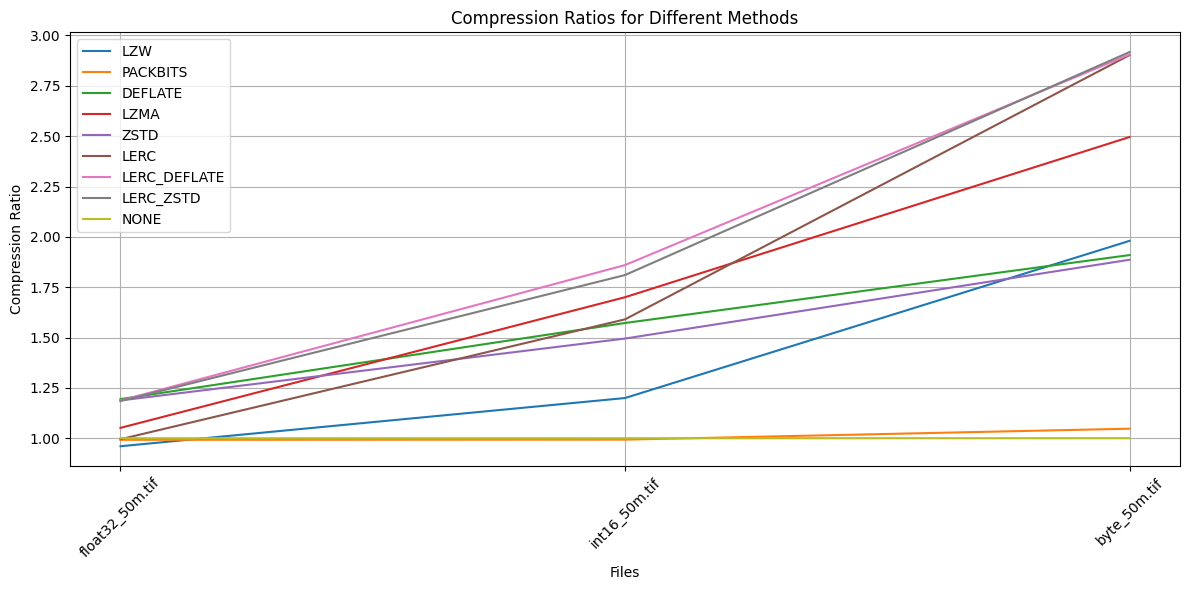

In [6]:
df = pd.DataFrame(results)
df.to_csv("../data/compression_results.csv", index=False)

plt.figure(figsize=(12, 6))
for compress_type in compress_types:
    subset = df[df["compression_type"] == compress_type]
    plt.plot(subset["file"], subset["compression_ratio"], label=compress_type)

plt.title("Compression Ratios for Different Methods")
plt.xlabel("Files")
plt.ylabel("Compression Ratio")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
df

,file,compression_type,original_size_mb,compressed_size_mb,compression_ratio,time_s
0,float32_50m.tif,LZW,47.683995,49.651052,0.960382,0.690339
1,float32_50m.tif,PACKBITS,47.683995,48.058838,0.992200,0.216816
2,float32_50m.tif,DEFLATE,47.683995,39.917294,1.194570,0.587064
3,float32_50m.tif,LZMA,47.683995,45.344562,1.051592,10.087119
4,float32_50m.tif,ZSTD,47.683995,40.147099,1.187732,0.358140
5,float32_50m.tif,LERC,47.683995,47.914801,0.995183,0.251501
6,float32_50m.tif,LERC_DEFLATE,47.683995,40.160550,1.187334,0.687084
7,float32_50m.tif,LERC_ZSTD,47.683995,40.232888,1.185199,0.699844
8,float32_50m.tif,NONE,47.683995,47.677960,1.000127,0.088403
9,int16_50m.tif,LZW,47.690187,39.750089,1.199750,0.772185
